[*********************100%***********************]  2 of 2 completed


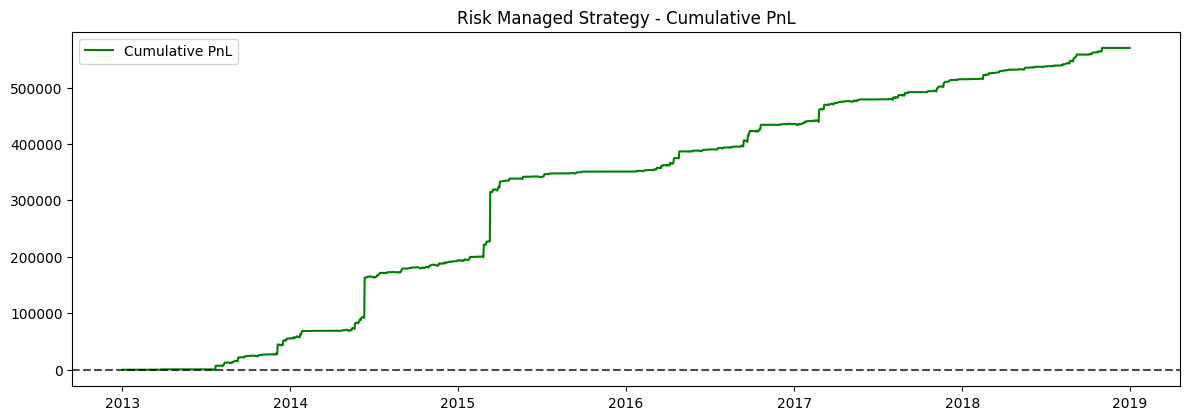

Final Cumulative PnL: 570135.45


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter


def KalmanFilterRegression(prices1, prices2):

    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)  
    
    prices1 = np.asarray(prices1)
    prices2 = np.asarray(prices2)
    
    obs_mat = np.vstack([prices1, np.ones(prices1.shape)]).T[:, np.newaxis]
    
    kf = KalmanFilter(
        n_dim_obs=1, 
        n_dim_state=2,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.ones((2, 2)),
        transition_matrices=np.eye(2),
        observation_matrices=obs_mat,
        observation_covariance=1.0,
        transition_covariance=trans_cov
    )
    
    state_means, state_covs = kf.filter(prices2)
    
    return state_means


def kalman_spread(price1, price2):
    state_means = KalmanFilterRegression(price2, price1)
    hedge_ratios = state_means[:, 0]
    alphas = state_means[:, 1]
    
    spread2 = price1 - hedge_ratios * price2 -alphas
    
    spread = abs(spread2)
    return pd.Series(spread, index=price1.index)

def stop_loss(spread, threshold):
    return spread > threshold

def position_sizing(spread, risk_factor):
    spread = pd.Series(spread)
    spread_volatility = spread.rolling(window=30).std()
    position_size = risk_factor / spread_volatility
    return position_size.fillna(0)

def volatility_threshold(spread, threshold):
    spread_volatility = pd.Series(spread).rolling(window=30).std()
    return spread_volatility > threshold

def backtest_with_risk_management(data, stock1, stock2, stop_loss_threshold=2, risk_factor=0.10, volatility_threshold_value=0.02):
    spread = calculate_kalman_spread(data[stock1], data[stock2])
    
    stop_loss_flag = stop_loss(spread, stop_loss_threshold)

    volatility_flag = volatility_threshold(spread, volatility_threshold_value)

    position_size = position_sizing(spread, risk_factor)*10000

    daily_returns = spread.pct_change().shift(-1).fillna(0)

    position = np.zeros(len(spread))*10000

    position[volatility_flag] = position_size[volatility_flag]

    position[stop_loss_flag] = 0

    pnl = position * daily_returns
    cumulative_pnl = pnl.cumsum()

    return cumulative_pnl, pnl

tickers = ["MSFT", "AAPL"]
start_date="2013-01-01"
end_date="2019-01-01"
data = data = yf.download(tickers, start=start_date, end=end_date)["Close"]


cumulative_pnl_rm, pnl_rm = backtest_with_risk_management(
    data, 'MSFT', 'AAPL',
    stop_loss_threshold=2,
    risk_factor=0.10,
    volatility_threshold_value=0.02
)

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(cumulative_pnl_rm, label="Cumulative PnL", color="green")
plt.axhline(0, color="black", linestyle="--", alpha=0.7)
plt.title("Risk Managed Strategy - Cumulative PnL")
plt.legend()



plt.tight_layout()
plt.show()

print(f"Final Cumulative PnL: {cumulative_pnl_rm.iloc[-1]:.2f}")
